In [1097]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fftpack import fft, ifft
import scipy.integrate as integrate

from tqdm import trange

from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import roc_auc_score
import gc
import seaborn as sns
from tqdm import tqdm

from sklearn import model_selection

from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from scipy import fftpack

from bokeh.plotting import figure,show,output_file, ColumnDataSource
from bokeh.io import push_notebook, output_notebook
from bokeh.layouts import column

from sklearn.model_selection import KFold

from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import peakutils

from numpy.fft import rfft, rfftfreq, irfft
from sklearn.metrics import matthews_corrcoef as mcc

import gc

output_notebook()

Loading BokehJS ...

In [4]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')
raw_train = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 1min 55s, sys: 55.1 s, total: 2min 50s
Wall time: 47.5 s


In [5]:
R = 0.02 #range of data sample in seconds
N_measurements = 8e5 #number of measurements in one cycle
D_0 = R/N_measurements #how often the signal is sampled


print('Sampling delta: {} ns'.format(D_0 * 1e9))
print('Sampling frequency: {} MHz'.format(1/(D_0 * 1e6)))
print('\n')
print('Nyquist frequency (f_max): {} MHz'.format(1/(D_0 * 1e6)/2))
print('Min frequency (f_min and also minimum discernible frequency gap): {} Hz'.format(1/R))

Sampling delta: 25.0 ns
Sampling frequency: 40.0 MHz


Nyquist frequency (f_max): 20.0 MHz
Min frequency (f_min and also minimum discernible frequency gap): 50.0 Hz


In [56]:
def get_fft(data_):
    aa = abs(fftpack.fft(data_))
    aa = aa[0:int(len(aa)/2)]
    aa = aa/aa.max()
    aa[aa < aa.std() * 0.6] = 0
    return aa

In [148]:
def fft_peaks(time_series, buckets = 100, stdevs = 0.7):
    FFT = abs(fftpack.fft(time_series))
    FFT[FFT < FFT.std() * stdevs] = 0
    
    freq_range = FFT.shape[0]//2
    buck_size = int(np.ceil((freq_range)/(buckets)))
    
    min_freq = 50
    
    segments = [(i,i+buck_size) for i in range(min_freq, freq_range, buck_size)]
    fft_components = [np.sum(FFT[ind_[0]:ind_[1]]) for ind_ in segments]
    fft_components = [(item/max(fft_components))*100 for item in fft_components]
    fft_ranges = [(int(ind_[0]*5e-2), int(ind_[1]*5e-2)) for ind_ in segments]
    
    return fft_components, fft_ranges

In [149]:
aa = get_fft(raw_train['421'])

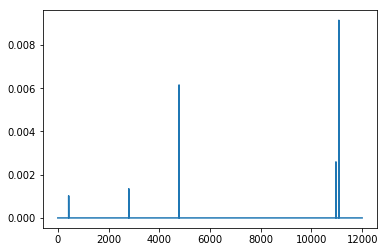

In [61]:
plt.plot(aa[8000:20000])
plt.show()

In [426]:
def generate_dataset(train_set, meta_train, test_):
    train_length = meta_train.shape[0]
    
    try:
        positive_length = len(meta_train[meta_train.target == 1])
    except: 
        pass
    
    hand_features = ['mean','max','min','std']
    
    buckets = 2000
    
    dataset = np.zeros((train_length, len(hand_features) + buckets + 2))
    try:
        imbalance_ = positive_length / train_length
    except:
        pass
    
    row_index = 0
    for i in trange(train_length):
#         if meta_train.loc[i, 'target'] == 1 or (random.random() < imbalance_):
        if test_:
            spectrum = train_set[str(i + 8712)]
        else:
            spectrum = train_set[str(i)]

        fft_integrals, _ = fft_peaks(spectrum, buckets)

        features_temp = np.concatenate([np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()]),
                                                 fft_integrals])

        try:
            label_temp = meta_train.loc[i, 'target']
        except:
            pass
        
        phase = meta_train.loc[i, 'phase']

        try:
            dataset[row_index,:] = np.concatenate([features_temp, [phase, label_temp]])
        except:
            dataset[row_index,:] = np.concatenate([features_temp, phase])
            
        row_index += 1

    return dataset

In [153]:
%%time
train = generate_dataset(raw_train, meta_train)
print('Train length: {}'.format(len(train)))


100%|██████████| 8712/8712 [25:33<00:00,  5.71it/s]

Train length: 8712
CPU times: user 24min 44s, sys: 39.9 s, total: 25min 24s
Wall time: 25min 33s


In [1223]:
from numba import jit

ModuleNotFoundError: No module named 'numba'

In [1222]:
@jit('float32(float32[:,:], int32)')
def feature_extractor(x, n_part=1000):
    lenght = len(x)
    pool = np.int32(np.ceil(lenght/n_part))
    output = np.zeros((n_part,))
    for j, i in enumerate(range(0,lenght, pool)):
        if i+pool < lenght:
            k = x[i:i+pool]
        else:
            k = x[i:]
        output[j] = np.max(k, axis=0) - np.min(k, axis=0)
    return output

NameError: name 'jit' is not defined

In [648]:
train = np.load('train_file.npy')

In [649]:
sample_train = train[:,:]
features = sample_train[:,:-1]
temp = sample_train[:,-1]

labels = np.zeros(shape = (sample_train.shape[0], 2))
labels[:,0] = temp
temp[temp == 0] = 2
temp[temp == 1] = 0
temp[temp == 2] = 1
labels[:,1] = temp

In [1027]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, 
                                                    test_size = 0.1)

In [1028]:
num_pos = len(Y_train) - np.sum(Y_train[:,0])
tot = len(Y_train)
num_neg = tot - num_pos

In [1062]:
Y_test.shape

(872, 2)

In [1029]:
num_neg, num_pos

(7366.0, 474.0)

In [1030]:
sess = None
def reset_vars():
    sess.run(tf.global_variables_initializer())

def reset_tf():
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

In [1195]:
import tensorflow as tf
EPOCHS = 200
BATCH_SIZE = 20

In [1196]:
reset_tf()

In [1197]:
cw = tf.constant([[1, num_neg/num_pos]], dtype = tf.float64)

In [1198]:
train_data = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
train_data = train_data.shuffle(10000)
train_data = train_data.batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
test_data = test_data.shuffle(10000)
test_data = test_data.batch(BATCH_SIZE)

iterator = tf.data.Iterator.from_structure(train_data.output_types, 
                                           train_data.output_shapes)

X,Y = iterator.get_next()


In [1199]:
train_init = iterator.make_initializer(train_data)
test_init = iterator.make_initializer(test_data)
init = tf.global_variables_initializer()

In [1200]:
# make a simple model
net_1 = tf.layers.dense(X, 200, activation=tf.tanh) # pass the first value from iter.get_next() as input
net_1 = tf.layers.dropout(net_1, rate = 0.5)
# net = tf.layers.dense(net, 100, activation=tf.tanh)
net_2 = tf.layers.dense(net_1, 10, activation=tf.tanh)
prediction = tf.layers.dense(net_2, 2, activation=tf.tanh)

truth = tf.argmin(Y,1)
preds_ = tf.argmin(prediction, 1)

In [1201]:
weights = tf.reduce_sum(tf.matmul(Y, tf.transpose(cw)), axis = 1)

In [1202]:
cros_ent = tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=Y)
loss = tf.reduce_mean(cros_ent * weights) 
# loss_unweighted = tf.reduce_mean(cros_ent)
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [1203]:
reset_vars()

In [1204]:
def eval_mcc():
    sess.run(test_init)
    truths = []
    predss = []
    Pv = []
    n_errors = 0
    try:
        while True:
            t_, p_, p__ = sess.run([truth, preds_, prediction])
            
            truths += list(t_)
            predss += list(p_)
            Pv += list(p__ [:,0])
    except tf.errors.OutOfRangeError:
        n_errors += 1
        pass
    
    return mcc(truths, predss), roc_auc_score(truths, Pv)

In [1205]:
res_ = np.zeros((EPOCHS, 3))

In [1206]:
for i in range(EPOCHS):
    sess.run(train_init)
    total_loss = 0
    n_batches = 0
    n_errors = 0
    try:
        while True:
            _, _loss = sess.run([optimizer, loss])
            total_loss += _loss
            n_batches += 1
    except tf.errors.OutOfRangeError:
        n_errors += 1
        pass

    ev_loss = eval_loss()
    
    if (i % 10) == 0:
        
        print('Epoch {} average loss: {} || {} || {}'.format(i, 
                                                       total_loss/n_batches, 
                                                       *eval_mcc()))
        
    b,c = eval_mcc()
    res_[i,:] = [total_loss/n_batches, b, c]
    
    

Epoch 0 average loss: 0.9555114161279206 || 0.4645053258529249 || 0.9197296458169139
Epoch 10 average loss: 0.442410034014969 || 0.593104902432838 || 0.9654653578849323
Epoch 20 average loss: 0.37998494730747395 || 0.6383074089358874 || 0.9659430154522223
Epoch 30 average loss: 0.3634853347072239 || 0.7111606940275836 || 0.9755916983114805
Epoch 40 average loss: 0.3115758757415983 || 0.6101001044579762 || 0.9659191325738578
Epoch 50 average loss: 0.30998924089182633 || 0.7171854071954706 || 0.9756394640682094
Epoch 60 average loss: 0.31840181051370825 || 0.7356647373549683 || 0.975137923622555
Epoch 70 average loss: 0.3140829393488726 || 0.6595293798539955 || 0.9659430154522223
Epoch 80 average loss: 0.296554522105813 || 0.6396606616503909 || 0.9609992596307707
Epoch 90 average loss: 0.29722256711601036 || 0.6887427769476118 || 0.9779561032695661
Epoch 100 average loss: 0.2939261311731643 || 0.7583217815288792 || 0.975997707243677
Epoch 110 average loss: 0.28512477002971726 || 0.710704

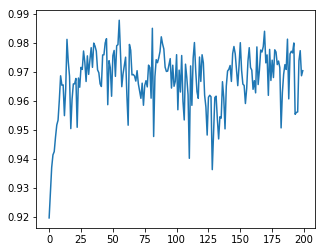

In [1208]:
plt.figure(figsize = (5,4))
plt.plot(res_[:,2])
plt.show()

# Predict and Submit

In [ ]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')
subset_test = pq.read_pandas('input/test.parquet').to_pandas()

In [434]:
def generate_dataset(train_set, meta_train, test_):
    train_length = meta_train.shape[0]
    
    try:
        positive_length = len(meta_train[meta_train.target == 1])
    except: 
        pass
    
    hand_features = ['mean','max','min','std']
    
    buckets = 2000
    
    if test_:
        dataset = np.zeros((train_length, len(hand_features) + buckets + 1))
    else:
        dataset = np.zeros((train_length, len(hand_features) + buckets + 2))
    
    try:
        imbalance_ = positive_length / train_length
    except:
        pass
    
    row_index = 0
    for i in trange(train_length):
#         if meta_train.loc[i, 'target'] == 1 or (random.random() < imbalance_):
        if test_:
            spectrum = train_set[str(i + 8712)]
        else:
            spectrum = train_set[str(i)]

        fft_integrals, _ = fft_peaks(spectrum, buckets)

        features_temp = np.concatenate([np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()]),
                                                 fft_integrals])

        try:
            label_temp = meta_train.loc[i, 'target']
        except:
            pass
        
        phase = meta_train.loc[i, 'phase']

        if test_:
            dataset[row_index,:] = np.concatenate([features_temp, [phase]])
        else:
            dataset[row_index,:] = np.concatenate([features_temp, [phase, label_temp]])
            
            
        row_index += 1

    return dataset

In [435]:
%%time
test = generate_dataset(subset_test, meta_test, True)
print('Test length: {}'.format(len(test)))

100%|██████████| 20337/20337 [1:01:23<00:00,  2.72it/s]

Test length: 20337
CPU times: user 59min 6s, sys: 1min 48s, total: 1h 55s
Wall time: 1h 1min 23s


In [1209]:
features_test = np.load('test_file.npy')

In [1210]:
labels_test = np.zeros(shape = (features_test.shape[0], 2))

In [1211]:
features_test.shape, labels_test.shape

((20337, 2005), (20337, 2))

In [1212]:
test_data_2 = tf.data.Dataset.from_tensor_slices((features_test, labels_test))
test_data_2 = test_data_2.batch(BATCH_SIZE)

In [1213]:
test_init_2 = iterator.make_initializer(test_data_2)

In [1214]:
sess.run(test_init_2)

In [1215]:
all_preds = []
try:
    while True:
        pr_ = sess.run(preds_)
        all_preds += list(pr_)
except tf.errors.OutOfRangeError:
    n_erorrs += 1
    pass

In [1216]:
rr = np.array(all_preds)

In [1217]:
(rr[rr == 0].shape[0]/rr.shape[0])*100

2.4536558981167333

In [1218]:
rr[rr == 0] = 2
rr[rr == 1] = 0
rr[rr == 2] = 1

In [1219]:
x_filename = meta_test.signal_id
predictions = rr
# predictions = predictor.predict(test)

In [1220]:
sub_df = pd.DataFrame({"signal_id":x_filename.values})
sub_df["target"] = pd.Series(predictions).round()
sub_df['signal_id'] = sub_df['signal_id'].astype(np.int64)
sub_df['target'] = sub_df['target'].astype(np.int64)
sub_df.to_csv("submission_15_mcc_p77.csv", index=False)
sub_df

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0
5,8717,0
6,8718,0
7,8719,0
8,8720,0
9,8721,0


In [1221]:
positive = len(sub_df[sub_df["target"] == 1])
print('Predicted positive: {}. {}% of total.'.format(positive, positive/len(sub_df)*100))

Predicted positive: 499. 2.4536558981167333% of total.
